Hi to all! 
I have added two models with slightly modified hyperparameters to this excellent notebook:https://www.kaggle.com/code/vaibhavjain2004/public-krni-pdi.
The best result is version 3, version 4 only added description.
Good luck to everyone!

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr/pip-packages
Processing /kaggle/input/pip-packages-icr/pip-packages/tabpfn-0.1.9-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost
import inspect
from collections import defaultdict
from tabpfn import TabPFNClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
sample = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

In [4]:
#drop Id column
train.drop(['Id'], axis=1, inplace=True)

In [5]:
# Convert the 'EJ' column in  binary values (1 for the first category, 2 for other categories)
first_category = train.EJ.unique()[0]
train['EJ'] = (train['EJ'] == first_category).astype(int) + 1
test['EJ'] = (test['EJ'] == first_category).astype(int) + 1

In [6]:
# Calculate the mean value for each numeric column
mean_values = train.select_dtypes(include='number').mean()

# Define a function to identify outliers using the IQR (Interquartile Range) method
def identify_outliers(column):
    if pd.api.types.is_numeric_dtype(column):
        Q1 = column.quantile(0.01)
        Q3 = column.quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = column[(column < lower_bound) | (column > upper_bound)]
        return outliers
    else:
        return pd.Series([])  # Return an empty Series for non-numeric columns

# Iterate through each numeric column and identify outliers
for column in train.select_dtypes(include='number').columns:
    outliers = identify_outliers(train[column])
    print(f"Column: {column}")
    print(f"Mean Value: {mean_values[column]}")
    print(f"Outliers: {outliers.tolist()}")
    print("-" * 30)


Column: AB
Mean Value: 0.477149358184765
Outliers: [6.161666]
------------------------------
Column: AF
Mean Value: 3502.0132207455435
Outliers: [28688.18766]
------------------------------
Column: AH
Mean Value: 118.62451267179904
Outliers: [1817.620554, 1910.123198, 1237.940805]
------------------------------
Column: AM
Mean Value: 38.96855212965964
Outliers: []
------------------------------
Column: AR
Mean Value: 10.12824205186386
Outliers: [178.943634, 173.534448]
------------------------------
Column: AX
Mean Value: 5.545576059967586
Outliers: [38.27088]
------------------------------
Column: AY
Mean Value: 0.06031962398703402
Outliers: [10.315851, 0.6019965, 0.6245295, 0.595602]
------------------------------
Column: AZ
Mean Value: 10.566446961102107
Outliers: []
------------------------------
Column: BC
Mean Value: 8.053011588330632
Outliers: [212.628626, 643.55396, 1463.693448]
------------------------------
Column: BD 
Mean Value: 5350.388655089141
Outliers: [43882.2785, 2727

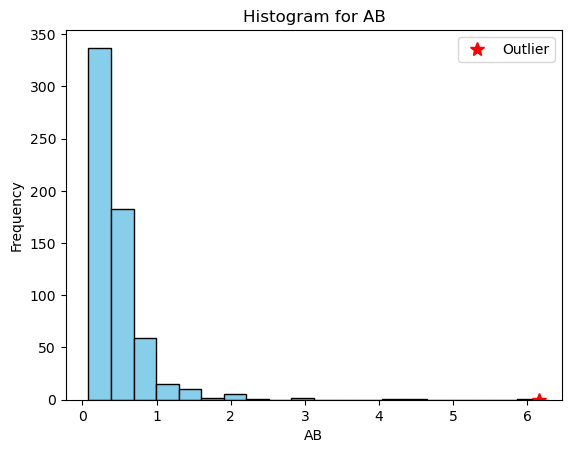

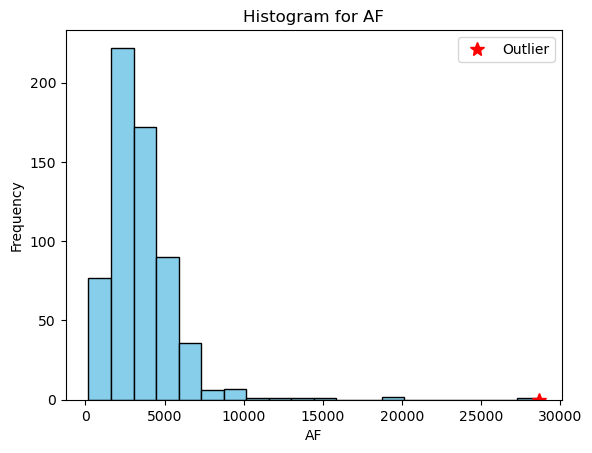

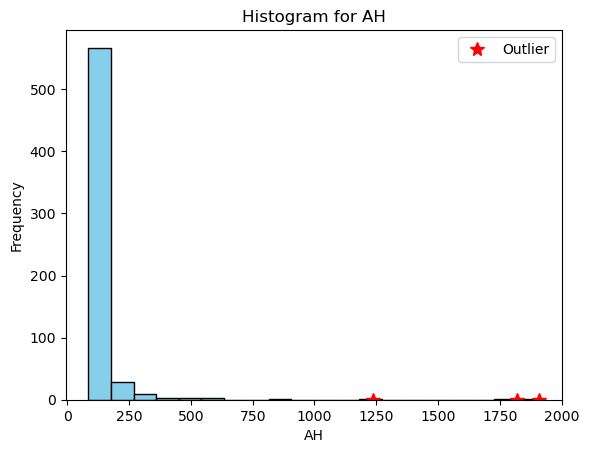

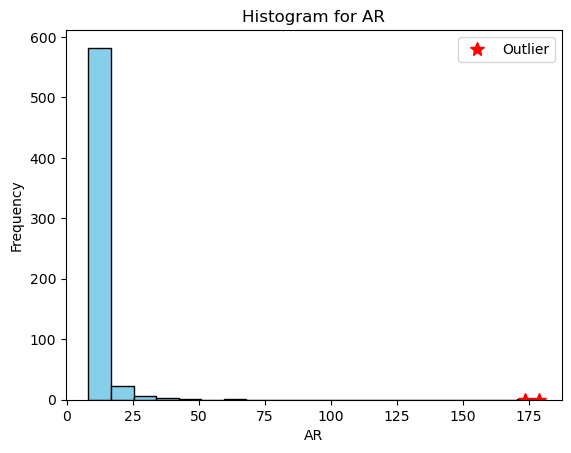

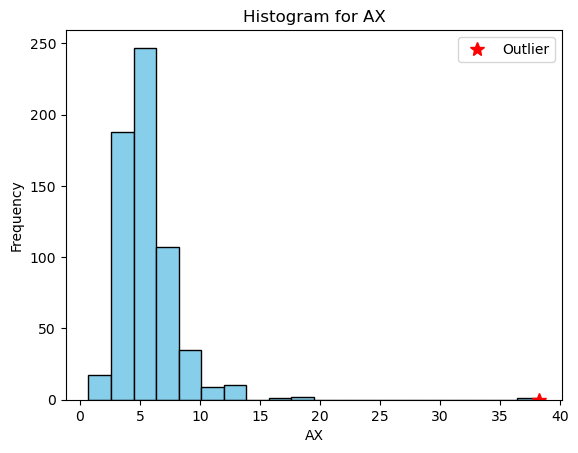

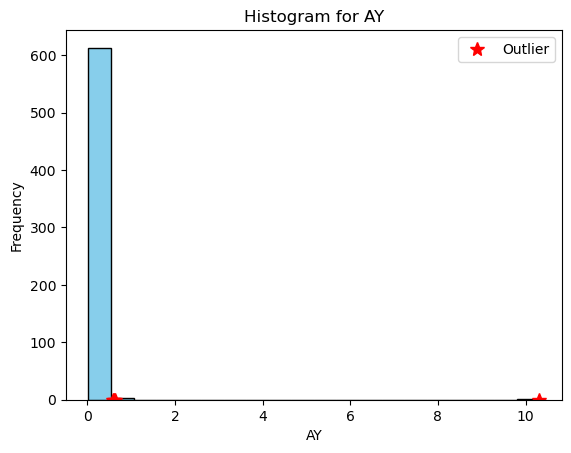

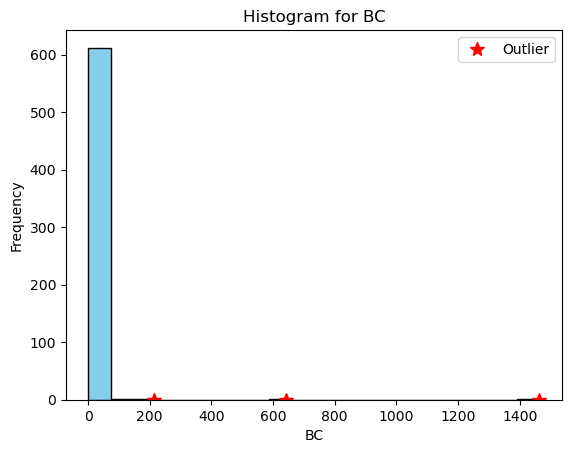

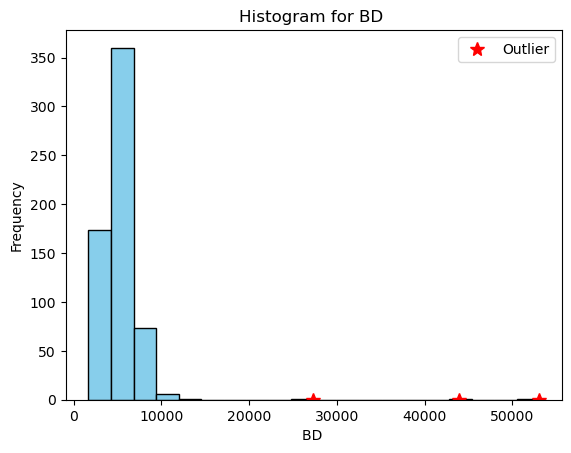

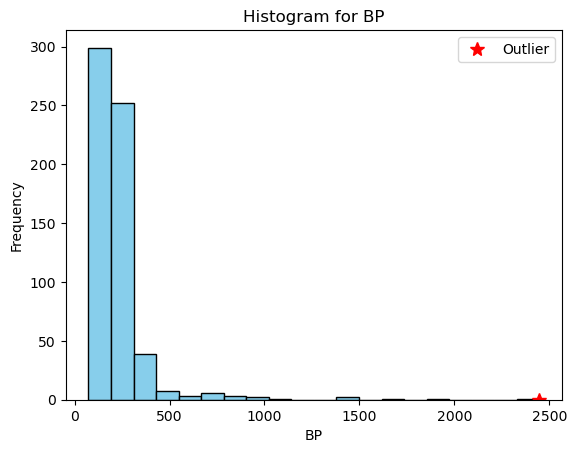

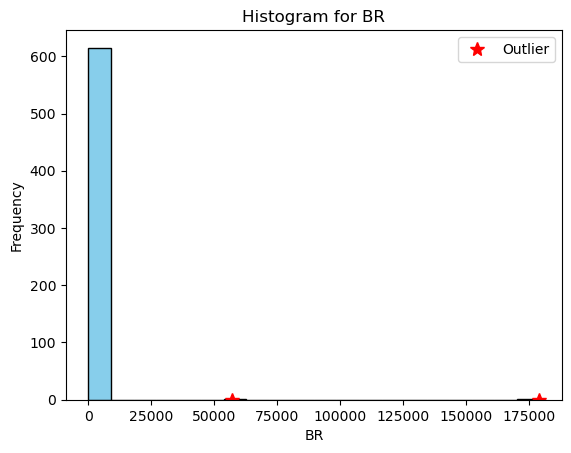

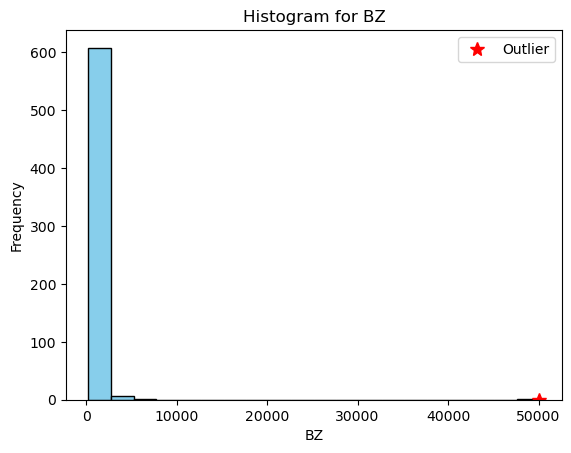

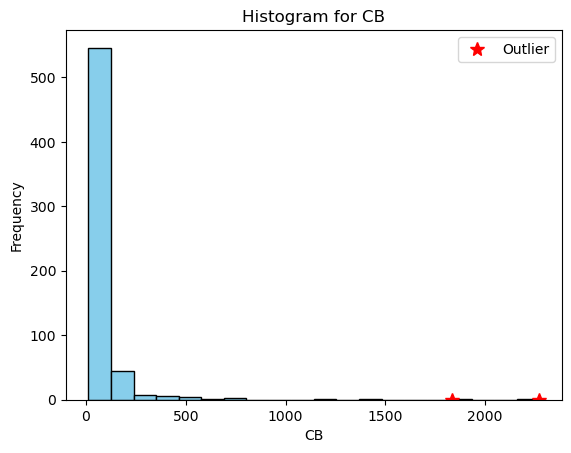

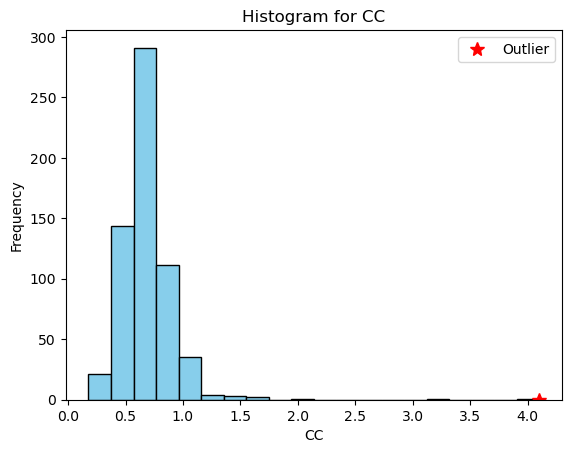

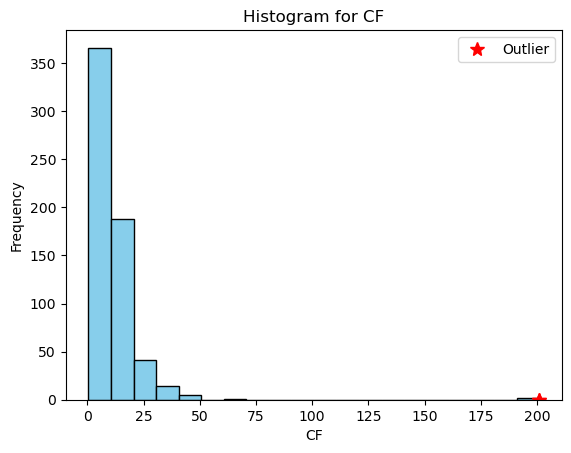

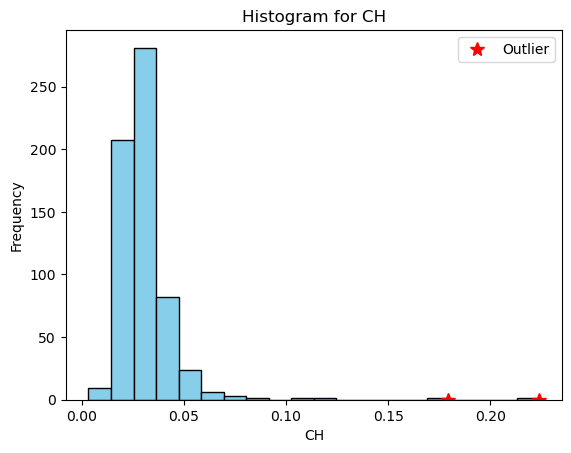

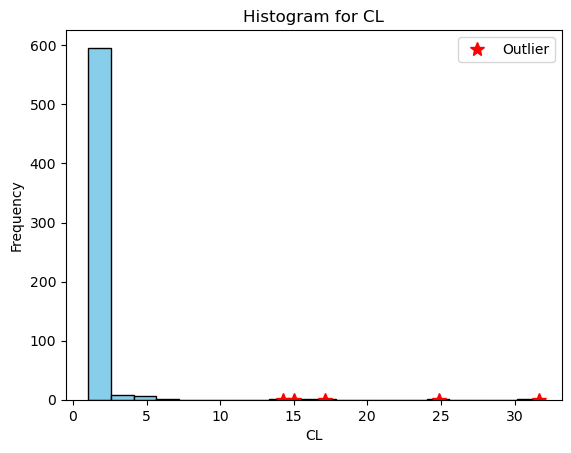

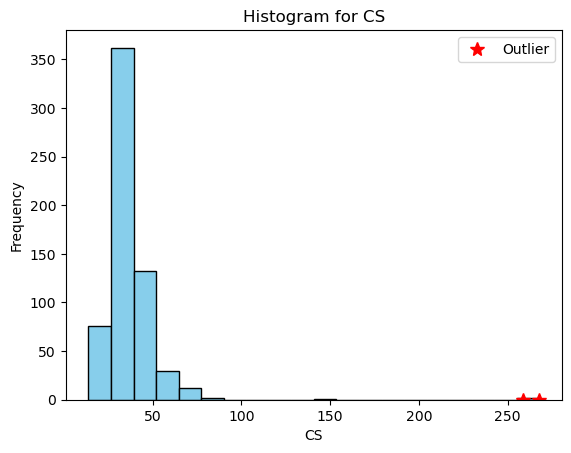

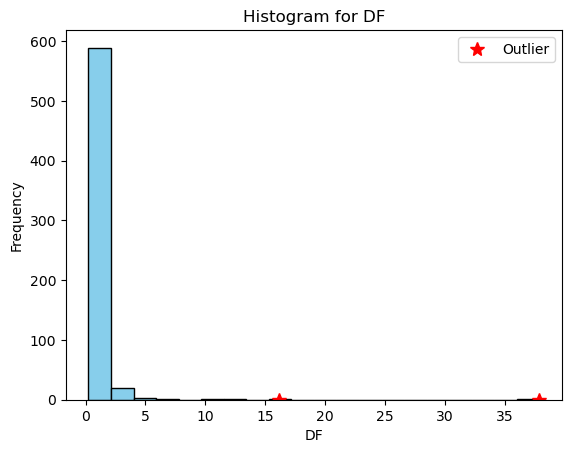

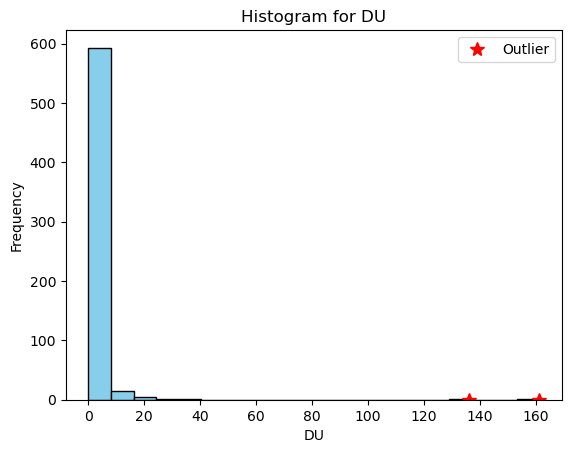

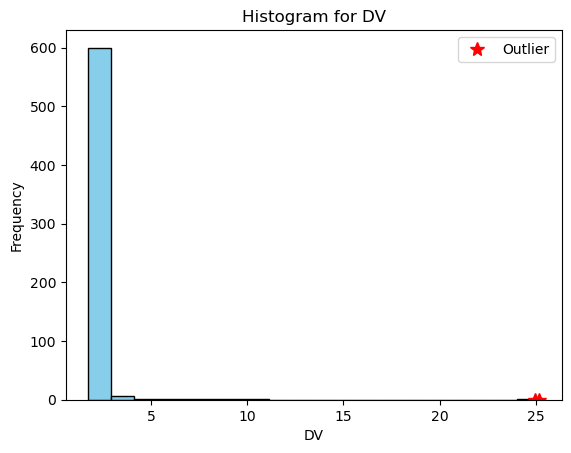

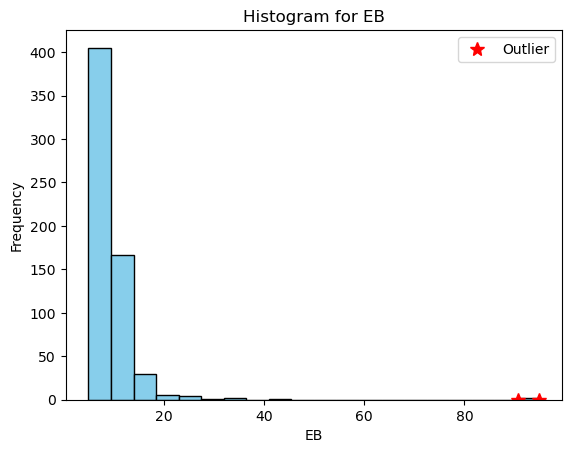

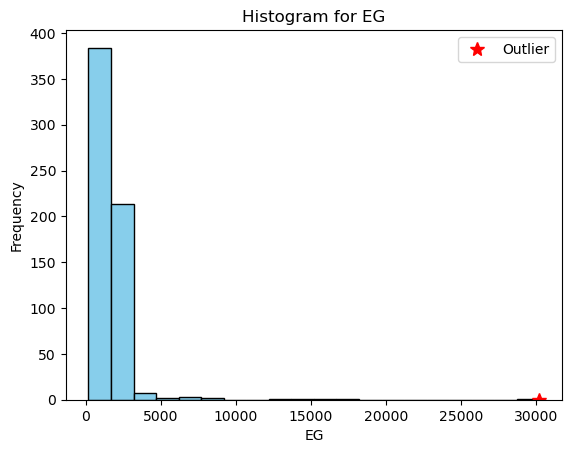

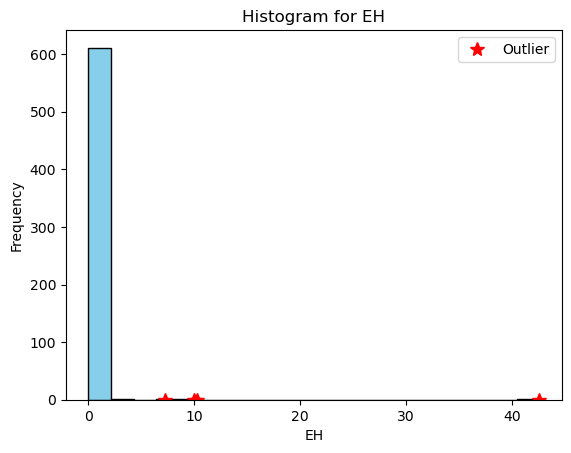

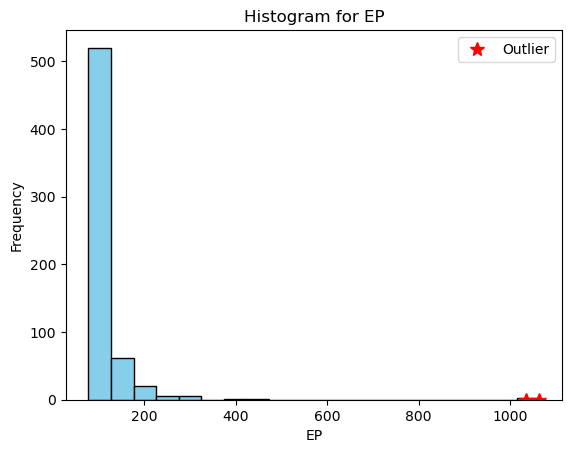

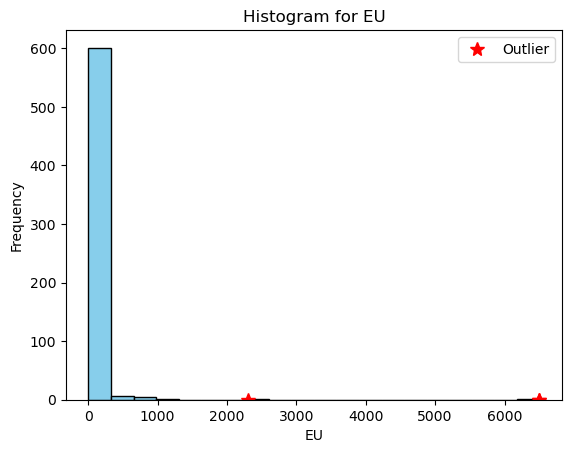

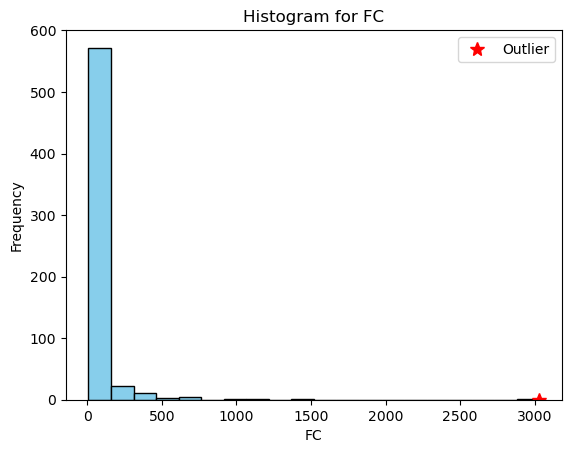

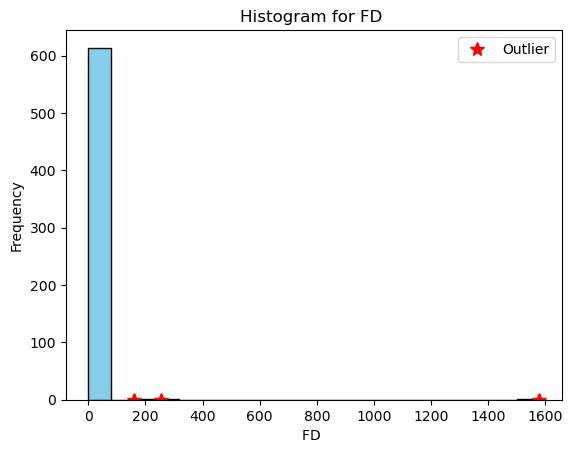

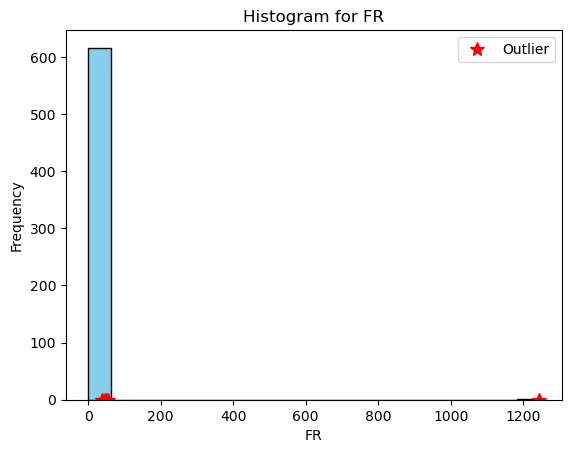

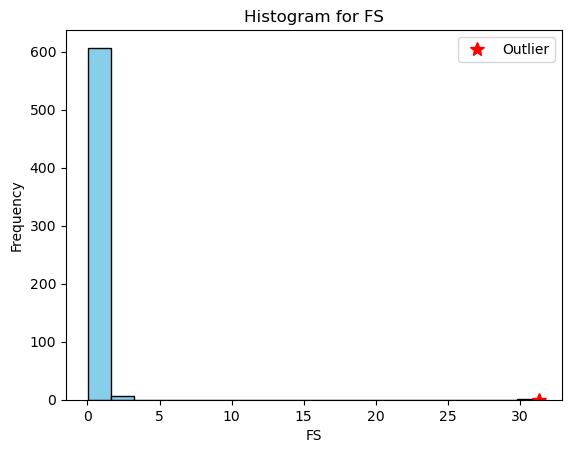

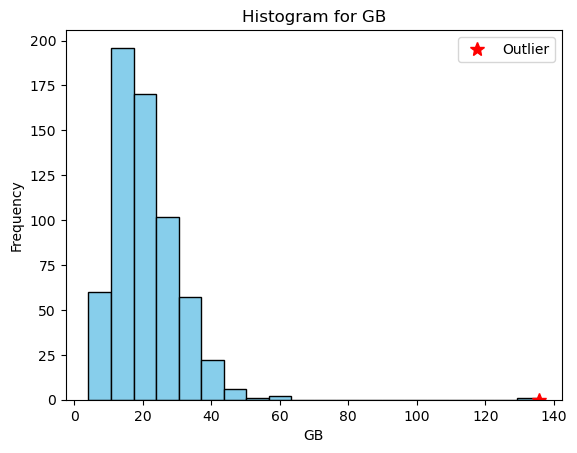

In [7]:
import matplotlib.pyplot as plt

# Get the list of columns with outliers
columns_with_outliers = []
for column in train.select_dtypes(include='number').columns:
    outliers = identify_outliers(train[column])
    if not outliers.empty:
        columns_with_outliers.append(column)

# Draw histograms for columns with outliers
for column in columns_with_outliers:
    plt.figure()
    plt.hist(train[column], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for {column}')

    # Mark outliers with a red star
    outliers = identify_outliers(train[column])
    plt.plot(outliers, [0] * len(outliers), 'r*', markersize=10, label='Outlier')
    
    plt.legend()
    plt.show()


In [9]:
# Iterate through each numeric column and identify outliers
for column in train.select_dtypes(include='number').columns:
    outliers = identify_outliers(train[column])
    print(f"Column: {column}")
    print(f"Mean Value: {mean_values[column]}")
    print(f"Outliers: {outliers.tolist()}")

    # Clip values to lower-bound and upper-bound
    Q1 = train[column].quantile(0.01)
    Q3 = train[column].quantile(0.99)
    train[column] = train[column].clip(lower=Q1, upper=Q3)

#     print(f"Clipped Mean Value: {train[column].mean()}")
#     print("-" * 30)

Column: AB
Mean Value: 0.477149358184765
Outliers: [6.161666]
Clipped Mean Value: 0.46060779260940043
------------------------------
Column: AF
Mean Value: 3502.0132207455435
Outliers: [28688.18766]
Clipped Mean Value: 3430.285846702107
------------------------------
Column: AH
Mean Value: 118.62451267179904
Outliers: [1817.620554, 1910.123198, 1237.940805]
Clipped Mean Value: 112.62015345695302
------------------------------
Column: AM
Mean Value: 38.96855212965964
Outliers: []
Clipped Mean Value: 36.90476272881686
------------------------------
Column: AR
Mean Value: 10.12824205186386
Outliers: [178.943634, 173.534448]
Clipped Mean Value: 9.592388543922207
------------------------------
Column: AX
Mean Value: 5.545576059967586
Outliers: [38.27088]
Clipped Mean Value: 5.486572248330632
------------------------------
Column: AY
Mean Value: 0.06031962398703402
Outliers: [10.315851, 0.6019965, 0.6245295, 0.595602]
Clipped Mean Value: 0.04196317954619125
------------------------------
Col

In [10]:
#find null
train.isnull().sum()

AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [11]:
#replace the null values with the most frequent value in each column
for column in train.columns:
    if train[column].isnull().sum() != 0:
        most_frequent_value = train[column].mode().iloc[0]
        train[column].fillna(most_frequent_value, inplace=True)

In [12]:
def random_under_sampler(df):
    # Calculate the number of samples for each label. 
    neg, pos = np.bincount(df['Class'])

    # Choose the samples with class label `1`.
    one_df = df.loc[df['Class'] == 1] 
    # Choose the samples with class label `0`.
    zero_df = df.loc[df['Class'] == 0]
    # Select `pos` number of negative samples.
    # This makes sure that we have equal number of samples for each label.
    zero_df = zero_df.sample(n=pos)

    # Join both label dataframes.
    undersampled_df = pd.concat([zero_df, one_df])

    # Shuffle the data and return
    return undersampled_df.sample(frac = 1)

In [13]:
train_good = random_under_sampler(train)

In [14]:
train_good.shape

(216, 57)

In [16]:
predictor_columns = [n for n in train.columns if n != 'Class' and n != 'Id']
x= train[predictor_columns]
y = train['Class']

In [18]:
from sklearn.model_selection import KFold as KF, GridSearchCV
cv_outer = KF(n_splits = 10, shuffle=True, random_state=42)
cv_inner = KF(n_splits = 5, shuffle=True, random_state=42)

In [19]:
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

In [20]:
class Ensemble():
    def __init__(self):
        self.imputer = SimpleImputer(missing_values=np.nan, strategy='median')

        self.classifiers =[xgboost.XGBClassifier(n_estimators=100,max_depth=3,learning_rate=0.2,subsample=0.9,colsample_bytree=0.85),
                          
                           xgboost.XGBClassifier(),
                           TabPFNClassifier(N_ensemble_configurations=24),
                          
                          TabPFNClassifier(N_ensemble_configurations=64)]
    
    def fit(self,X,y):
        y = y.values
        unique_classes, y = np.unique(y, return_inverse=True)
        self.classes_ = unique_classes
        first_category = X.EJ.unique()[0]
        X.EJ = X.EJ.eq(first_category).astype('int')
        X = self.imputer.fit_transform(X)
#         X = normalize(X,axis=0)
        for classifier in self.classifiers:
            if classifier==self.classifiers[2] or classifier==self.classifiers[3]:
                classifier.fit(X,y,overwrite_warning =True)
            else :
                classifier.fit(X, y)
     
    def predict_proba(self, x):
        x = self.imputer.transform(x)
#         x = normalize(x,axis=0)
        probabilities = np.stack([classifier.predict_proba(x) for classifier in self.classifiers])
        averaged_probabilities = np.mean(probabilities, axis=0)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1) 

In [21]:
from tqdm.notebook import tqdm

In [22]:
def training(model, x,y,y_meta):
    outer_results = list()
    best_loss = np.inf
    split = 0
    splits = 5
    models=[]
    for train_idx,val_idx in tqdm(cv_inner.split(x), total = splits):
        split+=1
        x_train, x_val = x.iloc[train_idx],x.iloc[val_idx]
        y_train, y_val = y_meta.iloc[train_idx], y.iloc[val_idx]
        #model = Ensemble()        
        model.fit(x_train, y_train)
        models.append(model)
        y_pred = model.predict_proba(x_val)
        probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
        p0 = probabilities[:,:1]
        p0[p0 > 0.86] = 1
        p0[p0 < 0.14] = 0
        y_p = np.empty((y_pred.shape[0],))
        for i in range(y_pred.shape[0]):
            if p0[i]>=0.5:
                y_p[i]= False
            else :
                y_p[i]=True
        y_p = y_p.astype(int)
        loss = balanced_log_loss(y_val,y_p)

        if loss<best_loss:
            best_model = model
            best_loss = loss
            print('best_model_saved')
        outer_results.append(loss)
        print('>val_loss=%.5f, split = %.1f' % (loss,split))
    print('LOSS: %.5f' % (np.mean(outer_results)))
    return best_model, models
    

In [23]:
from datetime import datetime
times = greeks.Epsilon.copy()
times[greeks.Epsilon != 'Unknown'] = greeks.Epsilon[greeks.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks.Epsilon == 'Unknown'] = np.nan

In [24]:
train_pred_and_time = pd.concat((train, times), axis=1)
test_predictors = test[predictor_columns]
first_category = test_predictors.EJ.unique()[0]
test_predictors.EJ = test_predictors.EJ.eq(first_category).astype('int')
test_pred_and_time = np.concatenate((test_predictors, np.zeros((len(test_predictors), 1)) + train_pred_and_time.Epsilon.max() + 1), axis=1)

In [25]:
ros = RandomOverSampler(random_state=42)

train_ros, y_ros = ros.fit_resample(train_pred_and_time, greeks.Alpha)
print('Original dataset shape')
print(greeks.Alpha.value_counts())
print('Resample dataset shape')
print( y_ros.value_counts())

Original dataset shape
A    509
B     61
G     29
D     18
Name: Alpha, dtype: int64
Resample dataset shape
B    509
A    509
D    509
G    509
Name: Alpha, dtype: int64


In [27]:
x_ros = train_ros.drop(['Class'],axis=1)
y_ = train_ros.Class

In [28]:
yt = Ensemble()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [30]:
m,models = training(yt,x_ros,y_,y_ros)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_33/3618796303.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


best_model_saved
>val_loss=0.36850, split = 1.0


/tmp/ipykernel_33/3618796303.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


best_model_saved
>val_loss=0.12386, split = 2.0


/tmp/ipykernel_33/3618796303.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.32402, split = 3.0


/tmp/ipykernel_33/3618796303.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.13220, split = 4.0


/tmp/ipykernel_33/3618796303.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.24145, split = 5.0
LOSS: 0.23800


In [31]:
y_.value_counts()/y_.shape[0]

1    0.75
0    0.25
Name: Class, dtype: float64

In [32]:
y_pred = m.predict_proba(test_pred_and_time)
#y_pred_list = []
#for m in models:
#    y_pred_list.append(m.predict_proba(test_pred_and_time))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [33]:
#y_pred=np.mean(y_pred_list, axis=0)
probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
p0 = probabilities[:,:1]
p0[p0 > 0.60] = 1
p0[p0 < 0.25] = 0

In [34]:
submission = pd.DataFrame(test["Id"], columns=["Id"])
submission["class_0"] = p0
submission["class_1"] = 1 - p0
submission.to_csv('submission.csv', index=False)

In [35]:
submission_df = pd.read_csv('submission.csv')
submission_df

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [36]:
submission_df.to_csv("/kaggle/working/submission.csv", index=False)